In [7]:
import os
import time

import numpy as np
import torch
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from torch.utils.data import Subset
from torchvision.transforms import (
    CenterCrop,
    ColorJitter,
    Compose,
    Grayscale,
    Normalize,
    RandomCrop,
    RandomHorizontalFlip,
    RandomGrayscale,
    RandomRotation, 
    Resize,
)

from tqdm import tqdm

from src.datasets import FPERankingPairsDataset, DatasetSubset
from src.losses import RankNetLoss
from src.modules import ResNetRankNet
from src.lightning_modules import RankNetModule, LossLoggingCallback
from src.utils import TransformBuilder, MetricLogger


In [2]:
# from typing import List, Optional, Union, Dict
# from torch.optim import Optimizer
# from torch.nn import Module
# from torch.optim.lr_scheduler import _LRScheduler


In [8]:
# list(model.named_modules())[1]

In [4]:
dset_root = '../../../../data/Streamflow/fpe_stations'
dset_root = os.path.abspath(dset_root)
stations = sorted([s for s in os.listdir(dset_root) if s not in ['FOXRC', 'GREENR', 'LANESV', 'WESTKILL', 'VLYB']])


In [5]:
station_idx = 0
print(stations[station_idx])
root_dir = os.path.join(dset_root, stations[station_idx], "FLOW_CFS")
pair_file = '../../../Jeff_data/stations/12-Avery Brook_Bridge_01171000/input/pairs.csv'
assert stations[station_idx] in pair_file, "Station mismatch!"
ds = FPERankingPairsDataset(root_dir, pair_file)

# subset the dataset into train and validation
train_indices = ds.data[ds.data['split'] == 'train'].index
val_indices = ds.data[ds.data['split'] == 'val'].index

# compute the mean and std over the training set
sample_means, sample_stds = ds.compute_mean_std(train_indices)
print(f"Mean: {sample_means}, Std: {sample_stds}")
ds.set_mean_std(sample_means, sample_stds)

# compute the input and resize shapes
input_size = 480
img_1, _, _ = ds[0]
img_1_height, img_1_width = img_1.shape[1], img_1.shape[2]
aspect = img_1_width /img_1_height
resize_shape = [input_size, np.int32(input_size * aspect)]
print(f"resize_shape: {resize_shape}")
input_shape = [
    np.int32(input_size * 0.8),
    np.int32(input_size * 0.8 * aspect),
]
print(f"input_shape: {input_shape}")

decolorize = False
augment = True
normalize = True

# create the transforms
def create_image_transforms(
    resize_shape,
    input_shape,
    decolorize=False,
    augmentation=True,
    normalization=True,
    means=None,
    stds=None,
):
    transform_builder = TransformBuilder()
    transform_builder.add_transforms(
        ["train", "eval"], [(Resize, {"size": resize_shape})]
    )
    if decolorize:
        transform_builder.add_transforms(
            ["train", "eval"], [(Grayscale, {"num_output_channels": 3})]
        )
    if augmentation:
        transform_builder.add_transforms(
            "train",
            [
                (RandomHorizontalFlip, {}),
                (RandomRotation, {"degrees": 10}),
                (RandomCrop, {"size": input_shape}),
                (ColorJitter, {}),
                (RandomGrayscale, {}) if not decolorize else None,
            ],
        )
    else:
        transform_builder.add_transforms("train", [(CenterCrop, {"size": input_shape})])
    transform_builder.add_transforms("eval", [(CenterCrop, {"size": input_shape})])
    if normalization:
        transform_builder.add_transforms(
            ["train", "eval"], [(Normalize, {"mean": means, "std": stds})]
        )
    return transform_builder.build()
transforms = create_image_transforms(resize_shape, input_shape, decolorize, augment, normalize, sample_means, sample_stds)

# create the train and validation datasets
train_ds = DatasetSubset(ds, train_indices, transforms["train"])
val_ds = DatasetSubset(ds, val_indices, transforms["eval"])

print("creating data loaders")
train_dl = torch.utils.data.DataLoader(
    train_ds, batch_size=64, shuffle=True, num_workers=12
)
val_dl = torch.utils.data.DataLoader(
    val_ds, batch_size=64, shuffle=False, num_workers=12
)



Avery Brook_Bridge_01171000


  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [01:07<00:00, 14.91it/s]


Mean: [0.47662222385406494, 0.48133382201194763, 0.42652153968811035], Std: [0.2604576647281647, 0.26564010977745056, 0.27263379096984863]
resize_shape: [480, 640]
input_shape: [384, 512]
creating data loaders


In [9]:
model_params ={
    "input_shape": (3, input_shape[0], input_shape[1]),
    "transforms": transforms,
    "resnet_size": 18,
    "truncate": 2,
    "pretrained": True,
}

module = RankNetModule(model_params, RankNetLoss(), lr=1e-3, freeze_layers=['resnetbody'], unfreeze_after=1)
early_stop_callback = EarlyStopping(monitor="val_loss", patience=3, mode="min")
loss_logging_callback = LossLoggingCallback(filepath="./losses.pkl")
checkpoint_callback = ModelCheckpoint(
    monitor="val_loss",
    dirpath="checkpoints",
    filename="best-checkpoint-{epoch:02d}-{val_loss:.2f}",
    save_top_k=1,
    mode="min",
    save_last=True,  # Save the model after each epoch
)
trainer = Trainer(max_epochs=2, callbacks=[early_stop_callback, loss_logging_callback, checkpoint_callback])
trainer.fit(module, train_dl, val_dl)

Trainer will use only 1 of 8 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=8)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name      | Type          | Params
--------------------------------------------
0 | model     | ResNetRankNet | 11.3 M
1 | criterion | RankNetLoss   | 0     
--------------------------------------------
147 K     Trainable params
11.2 M    Non-trainable params
11.3 M    Total params
45.297    Total estimated model params size (MB)


Epoch 0: 100%|██████████| 79/79 [01:55<00:00,  0.68it/s, v_num=9, train_loss_step=0.674, val_loss=0.653, train_loss_epoch=0.672]

Metric val_loss improved. New best score: 0.653


Epoch 1: 100%|██████████| 79/79 [02:01<00:00,  0.65it/s, v_num=9, train_loss_step=0.605, val_loss=0.608, train_loss_epoch=0.629]

Metric val_loss improved by 0.045 >= min_delta = 0.0. New best score: 0.608
`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 79/79 [02:01<00:00,  0.65it/s, v_num=9, train_loss_step=0.605, val_loss=0.608, train_loss_epoch=0.629]


In [ ]:


device = torch.device("cuda:0")
model = torch.nn.DataParallel(
    model,
    device_ids=[
        0,
    ],
)
model.to(device)

# # # # # # # # # # # # # # # # # # # # # # # # #
# INITIALIZE LOSS, OPTIMIZER, SCHEDULER
# # # # # # # # # # # # # # # # # # # # # # # # #
criterion = RankNetLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, "min", patience=1, factor=0.5
)

# # # # # # # # # # # # # # # # # # # # # # # # #
# INITIALIZE LOSS LOGS
# # # # # # # # # # # # # # # # # # # # # # # # #
metriclogs = {}
metriclogs["epoch"] = []
metriclogs["train_loss"] = []
metriclogs["val_loss"] = []

trainer = Trainer(
    model=model,
    criterion=criterion,
    validation_metrics=[criterion],
    optimizer=optimizer,
    device=device,
    scheduler=scheduler,
    transforms=transforms,
    transforms_params={
        "aspect": aspect,
        "input_shape": input_shape,
        "img_sample_means": sample_means,
        "img_sample_stds": sample_stds,
    }
)
for epoch in range(0, 3):
    print(f"start training (epoch={epoch})")
    metriclogs["epoch"].append(epoch)

    # start_time = time.time()
    train_loss, train_time = trainer.train_one_epoch(train_dl, epoch)
    # stop_time = time.time()
    metriclogs["train_loss"].append(train_loss)
    # print("train step took %0.1f s" % (stop_time - start_time))
    print("train loss = %0.2f" % (train_loss))
    print(
        f"[Epoch {epoch}|train]\t{train_time:.2f} s\t{(train_loss):.4f}"
    )
    # validate on val set
    # start_time = time.time()
    val_metrics, val_time = trainer.validate(val_dl, epoch)
    # print(val_loss)
    # stop_time = time.time()
    metriclogs["val_loss"].append(val_metrics['RankNetLoss'])
    # print("val step took %0.1f s" % (stop_time - start_time))
    print("val loss = %0.2f" % (val_metrics['RankNetLoss']))
    print(
        f"[Epoch {epoch}|val]\t{val_time:.2f} s\t{(val_metrics['RankNetLoss']):.4f}"
    )

    # update lr scheduler
    scheduler.step(val_loss['RankNetLoss'])

    # after 2 epochs unfreeze the resnet backbone
    if epoch == 1:
        for p in list(model.children())[0].parameters():
            p.requires_grad = True
        # reinitialize the optimizer and scheduler
        optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, "min", patience=1, factor=0.5
        )
        trainer.optimizer = optimizer
        trainer.scheduler = scheduler
        


/opt/conda/envs/fpe-model.dev-amrita/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/envs/fpe-model.dev-amrita/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


start training (epoch=0)


Epoch 0: 100%|██████████| 40/40 [00:37<00:00,  1.08it/s]


train loss = 0.61
[Epoch 0|train]	37.77 s	0.6051


Validation 0: 100%|██████████| 10/10 [00:10<00:00,  1.02s/it]

{'RankNetLoss': 0.5913233399391175}
val loss = 0.59
[Epoch 0|val]	0.32 s	0.5913
start training (epoch=1)



Epoch 1: 100%|██████████| 40/40 [00:36<00:00,  1.10it/s]


train loss = 0.57
[Epoch 1|train]	36.99 s	0.5734


Validation 1: 100%|██████████| 10/10 [00:10<00:00,  1.05s/it]

{'RankNetLoss': 0.5605365693569183}
val loss = 0.56
[Epoch 1|val]	0.33 s	0.5605
start training (epoch=2)



Epoch 2: 100%|██████████| 40/40 [00:37<00:00,  1.07it/s]

train loss = 0.52
[Epoch 2|train]	37.91 s	0.5171



Validation 2: 100%|██████████| 10/10 [00:10<00:00,  1.02s/it]

{'RankNetLoss': 0.4938188463449478}
val loss = 0.49
[Epoch 2|val]	0.33 s	0.4938


Applying transform
torch.Size([384, 512, 3]) tensor(0.0025) tensor(0.9614)
Applying transform
Applying transform
torch.Size([384, 512, 3]) tensor(0.) tensor(1.)
Applying transform
Applying transform
torch.Size([384, 512, 3]) tensor(0.) tensor(1.)
Applying transform


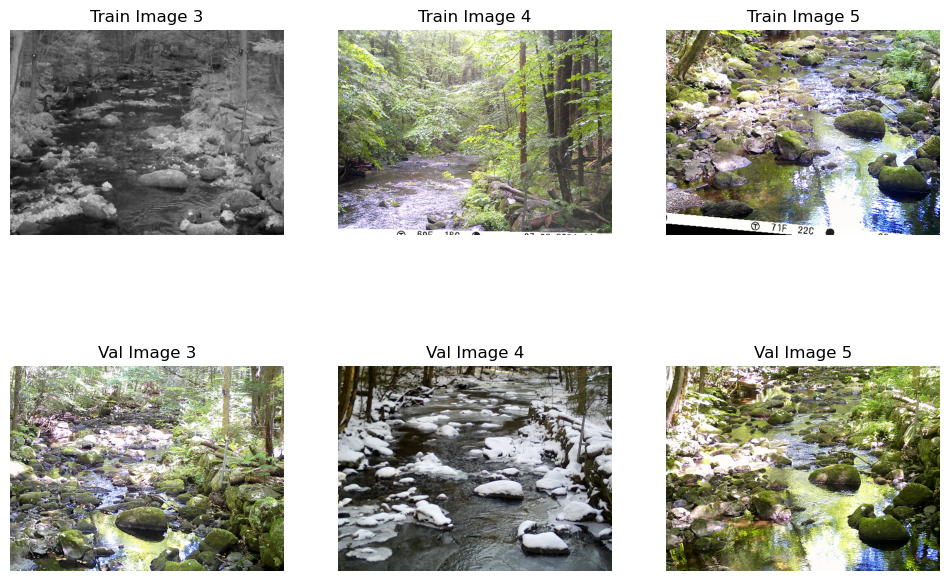

In [12]:
# plot a few of the train images (with transformations)
import matplotlib.pyplot as plt
import numpy as np

def denormalize(image, mean, std):
    image = image.permute(1, 2, 0)  # CxHxW to HxWxC
    image = image * std + mean  # denormalize
    image = image.clip(0, 1)  # clip values to range [0, 1]
    return image

mean = torch.tensor(sample_means)
std = torch.tensor(sample_stds)

fig, axs = plt.subplots(2, 3, figsize=(12, 8))
for i in range(3):
    idx = i + 3
    img, _, _ = train_ds[idx]
    img = denormalize(img, mean, std)
    print(img.shape, img.min(), img.max())
    axs[0, i].imshow(img)
    axs[0, i].axis("off")
    axs[0, i].set_title(f"Train Image {idx}")

    img, _, _ = val_ds[idx]
    img = denormalize(img, mean, std)
    axs[1, i].imshow(img)
    axs[1, i].axis("off")
    axs[1, i].set_title(f"Val Image {idx}")

In [31]:
# class Trainer:
#     def __init__(self, model, optimizer, criterion, scheduler, device, logger, checkpoint_dir, log_interval=10, verbose=True):
#         self.model = model
#         self.criterion = criterion
#         self.optimizer = optimizer
#         self.scheduler = scheduler
#         self.device = device
#         self.logger = logger
#         self.checkpoint_dir = checkpoint_dir
#         self.log_interval = log_interval
#         self.verbose = verbose

#     def training_step(self, batch):
#         """
#         Performs a single training step.
#         """
#         self.model.train()
#         self.optimizer.zero_grad()

#         if isinstance(self.criterion, (torch.nn.MarginRankingLoss, RankNetLoss)):
#             # Handle paired inputs and outputs
#             inputs1, inputs2, labels = batch
#             inputs1, inputs2, labels = inputs1.to(self.device), inputs2.to(self.device), labels.to(self.device)
#             outputs1, outputs2 = self.model(inputs1, inputs2)
#             loss = self.criterion(outputs1, outputs2, labels)
#         else:
#             # Handle single input and output
#             inputs, labels = batch
#             inputs, labels = inputs.to(self.device), labels.to(self.device)
#             outputs = self.model(inputs)
#             loss = self.criterion(outputs, labels)

#         loss.backward()
#         self.optimizer.step()
#         return loss.item()

#     def validation_step(self, batch):
#         """
#         Performs a single validation step.
#         """
#         self.model.eval()
#         with torch.no_grad():

#             if isinstance(self.criterion, (torch.nn.MarginRankingLoss, RankNetLoss)):
#                 # Handle paired inputs and outputs
#                 inputs1, inputs2, labels = batch
#                 inputs1, inputs2, labels = inputs1.to(self.device), inputs2.to(self.device), labels.to(self.device)
#                 outputs1, outputs2 = self.model(inputs1, inputs2)
#                 loss = self.criterion(outputs1, outputs2, labels)
#             else:
#                 # Handle single input and output
#                 inputs, labels = batch
#                 inputs, labels = inputs.to(self.device), labels.to(self.device)
#                 outputs = self.model(inputs)
#                 loss = self.criterion(outputs, labels)

#         return loss.item()

#     def train_one_epoch(self, dataloader, loss_tracker, current_epoch):
#         """
#         Trains the model for one epoch.
#         """
#         for bidx, batch in enumerate(tqdm(dataloader)):
#             loss = self.training_step(batch)
#             if loss_tracker is not None:
#                 loss_tracker.update(loss)
#             if self.verbose and bidx % self.log_interval == 0:
#                 print(f"Batch {bidx + 1}/{len(dataloader)} - Loss: {loss:.4f}")
#             self.logger.log_metric('train_loss', loss, step=current_epoch)
#         self.scheduler.step()
#         return loss_tracker.avg

#     def validate_one_epoch(self, dataloader):
#         """
#         Validates the model for one epoch.
#         """
#         pass

#     def save_checkpoint(self, epoch):
#         torch.save({
#             'model_state_dict': self.model.state_dict(),
#             'optimizer_state_dict': self.optimizer.state_dict(),
#             'scheduler_state_dict': self.scheduler.state_dict(),
#         }, os.path.join(self.checkpoint_dir, f'checkpoint_{epoch}.pt'))

#     def load_checkpoint(self, checkpoint_path):
#         checkpoint = torch.load(checkpoint_path)
#         self.model.load_state_dict(checkpoint['model_state_dict'])
#         self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
#         self.scheduler.load_state_dict(checkpoint['scheduler_state_dict'])


#     def log_metrics(self, metrics):
#         """
#         Logs the specified metrics.
#         """
#         pass

#     def set_requires_grad(self, layers, requires_grad=True):
#         """
#         Set requires_grad for specific layers.
#         """
#         for name, param in self.model.named_parameters():
#             if name in layers:
#                 param.requires_grad = requires_grad


#     def evaluate(self, dataloader):
#         """
#         Evaluates the model on the provided data.
#         """
#         pass

#     def predict(self, inputs):
#         """
#         Uses the model to make predictions on the provided inputs.
#         """
#         pass

In [4]:
# # import torch

# num_gpus = os.environ.get('SM_NUM_GPUS')
# if num_gpus is not None:
#     num_gpus = int(num_gpus)
# else:
#     num_gpus = torch.cuda.device_count()
# print(f"num_gpus: {num_gpus}")
# # num_gpus = os.environ.get('SM_NUM_GPUS', os.environ.get('CUDA_VISIBLE_DEVICES', 0))
# # print(f"num_gpus: {num_gpus}")
# # num_gpus = len(num_gpus.split(',')) if isinstance(num_gpus, str) else int(num_gpus)

# # if num_gpus > 0:
# #     device = torch.device(f"cuda:{0}")
# #     print(f"using GPU {0} to train")
# # else:
# #     device = torch.device("cpu")
# #     print("using CPU to train")

# # # ...

# # if num_gpus > 1:
# #     model = torch.nn.DataParallel(
# #         model,
# #         device_ids=list(range(num_gpus)),
# #     )
# # model.to(device)

num_gpus: 8


In [2]:

# dset = FPEDataset(os.path.join(dset_root, stations[0], "FLOW_CFS"))
# dset.station
# dset.data.head(2)
# dset.compute_mean_std()

## THE FOLLOWING IS SLOW! DO NOT RUN UNLESS NECESSARY
# def check_image_sizes(dataset):
#     """Check that all images in the dataset have the same size."""
#     sizes = set()
#     for idx in tqdm(range(len(dataset))):
#         image = dataset.get_image(idx)
#         sizes.add(image.shape)
#         if len(sizes) > 1:
#             print(f"Found different image sizes: {sizes}")
#             print(sizes)
#             break
#     return len(sizes) == 1

# # Usage:
# print(check_image_sizes(dset))

In [3]:
station_root = os.path.join(dset_root, stations[0], "FLOW_CFS")
annot_f = '../../../Jeff_data/stations/12-Avery Brook_Bridge_01171000/input/pairs.csv'
assert stations[0] in annot_f, "Station mismatch!"
rdset = FPERankingPairsDataset(station_root, annot_f)

# subset the dataset into train and validation
train_indices = rdset.data[rdset.data['split'] == 'train'].index
val_indices = rdset.data[rdset.data['split'] == 'val'].index

# compute the mean and std over all the data
mean, std = rdset.compute_mean_std()
print(f"Mean: {mean}, Std: {std}")

# compute the mean and std over the training set
sample_means, sample_stds = rdset.compute_mean_std(train_indices)
print(f"Mean: {sample_means}, Std: {sample_stds}")
rdset.set_mean_std(sample_means, sample_stds)

# create the train and validation datasets
train_ds = Subset(rdset, train_indices)
val_ds = Subset(rdset, val_indices)


  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [01:22<00:00, 12.10it/s]


Mean: [0.4778338372707367, 0.4818498194217682, 0.42878246307373047], Std: [0.26026880741119385, 0.26533448696136475, 0.27215224504470825]


100%|██████████| 1000/1000 [01:19<00:00, 12.52it/s]

Mean: [0.47599586844444275, 0.4803962707519531, 0.4272591471672058], Std: [0.256852924823761, 0.26207759976387024, 0.26937758922576904]


In [4]:
print(rdset.means)
print(rdset.stds)
print(rdset.image_shape)
img_1, img_2, label = train_ds[0]
print(type(img_1), img_1.shape)
print(type(img_2), img_2.shape)
print(type(label), label)

[0.47599586844444275, 0.4803962707519531, 0.4272591471672058]
[0.256852924823761, 0.26207759976387024, 0.26937758922576904]
torch.Size([3, 1536, 2048])
<class 'torch.Tensor'> torch.Size([3, 1536, 2048])
<class 'torch.Tensor'> torch.Size([3, 1536, 2048])
<class 'numpy.int64'> 1


In [4]:
# print("loading pairs from csv files")
#     pairs_df = load_pairs(os.path.join(args.values_dir, args.pairs_file))
#     train_df = pairs_df[pairs_df["split"] == "train"]
#     print(f"train_df: {train_df.shape[0]} rows")
#     val_df = pairs_df[pairs_df["split"] == "val"]
#     print(f"val_df: {val_df.shape[0]} rows")

#     print("creating train dataset")
#     train_ds = FPERankingPairsDataset(
#         train_df,
#         args.images_dir,
#     )

#     print("computing image stats")
#     img_sample_mean, img_sample_std = train_ds.compute_mean_std(args.num_image_stats)
#     print(f"img_sample_mean: {img_sample_mean}")
#     print(f"img_sample_std: {img_sample_std}")

#     pair = train_ds.get_pair(0)
#     image = train_ds.get_image(pair["filename_1"])
#     aspect = image.shape[2] / image.shape[1]
#     resize_shape = [args.input_size, np.int32(args.input_size * aspect)]
#     print(f"resize_shape: {resize_shape}")

#     input_shape = [
#         np.int32(args.input_size * 0.8),
#         np.int32(args.input_size * 0.8 * aspect),
#     ]
#     print(f"input_shape: {input_shape}")

#     image_transforms = create_image_transforms(
#         resize_shape,
#         input_shape,
#         means=img_sample_mean,
#         stds=img_sample_std,
#         decolorize=args.decolorize,
#         augmentation=args.augment,
#         normalization=args.normalize,
#     )
#     train_ds.transform = image_transforms["train"]

#     print("creating val datasets")
#     print(f"val df: {len(val_df)}")
#     val_ds = FPERankingPairsDataset(
#         val_df,
#         args.images_dir,
#         transform=image_transforms["eval"],
#     )
#     print(f"val ds: {len(val_ds)}")

#     print("creating data loaders")
#     train_dl = torch.utils.data.DataLoader(
#         train_ds, batch_size=args.batch_size, shuffle=True, num_workers=args.num_workers
#     )
#     val_dl = torch.utils.data.DataLoader(
#         val_ds, batch_size=args.batch_size, shuffle=False, num_workers=args.num_workers
#     )

In [5]:
item = rdset[0]
im1, im2, label = item[0], item[1], item[2]
print(im1.shape, im2.shape, label)
print(type(im1), type(im2), type(label))

torch.Size([3, 1536, 2048]) torch.Size([3, 1536, 2048]) UNKNOWN
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'str'>


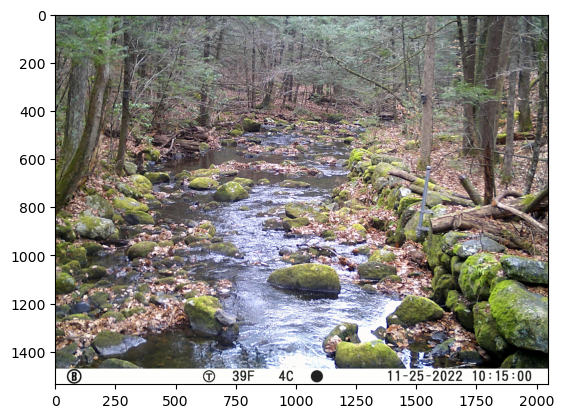

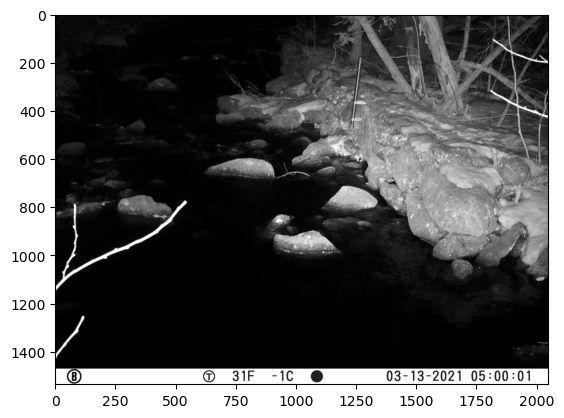

In [6]:
import matplotlib.pyplot as plt
import numpy as np
im1_numpy = im1.numpy()
im2_numpy = im2.numpy()
plt.imshow(im1_numpy.transpose(1, 2, 0))
plt.show()
plt.imshow(im2_numpy.transpose(1, 2, 0))
plt.show()
